## Visualization of Schism results

In [72]:
#to use the full width of the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [73]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.tri as tri
from netCDF4 import Dataset
from scipy.io import loadmat
import pandas as pd
from scipy.interpolate import griddata
from tqdm import tqdm

In [74]:
from Poseidon.utils import *


In [75]:
from matplotlib import animation,rc

rc('animation',html='html5')


In [59]:
PATH='/home/critechproc/STORAGE/SCHISM/EUROP/'

In [77]:
#g=loadmat('/home/critechproc/STORAGE/SCHISM/test1/nodes.mat')
#g['nodes'][:].shape

In [78]:
grid=PATH+'hgrid.gr3'

In [79]:
#extract number of elements, number of nodes
ne,nn = pd.read_csv(grid,header=0,skiprows=1,nrows=0,delim_whitespace=True)

In [80]:
ne=int(ne)
nn=int(nn)

In [81]:
#read lon,lat,depth for all nodes
q=pd.read_csv(grid,skiprows=2,header=None,delim_whitespace=True,engine='python',nrows=nn,names=['id','x','y','z'])

In [82]:
q=q.set_index(['id'])

In [83]:
q.head()

,x,y,z
id,,,
1,39.457138,47.262344,24.941161
2,39.457632,47.211644,24.919153
3,39.460017,47.150657,24.880700
4,39.389615,47.226132,25.379718
5,39.369948,47.271625,25.528124


In [84]:
e = pd.read_csv(grid,skiprows=nn+2,header=None,delim_whitespace=True,engine='python',nrows=ne,names=['id','nv','a','b','c'])

In [85]:
e=e.set_index(['id'])

In [60]:
r = Dataset(PATH+'outputs/schism_history.nc')

In [61]:
r.variables.keys()

[u'ocean_time',
 u'ocean_time_day',
 u'ocean_time_str',
 u'kbp00',
 u'idry',
 u'WATLEV',
 u'Uwind',
 u'Vwind',
 u'davx',
 u'davy',
 u'qnon']

In [62]:
U = r.variables['davx'][:]
V = r.variables['davy'][:]

In [63]:
h = r.variables['WATLEV'][:]

In [64]:
h

array([[-0.01535489, -0.01424446, -0.01302942, ..., -0.00974072,
        -0.00923765, -0.00956598],
       [-0.0228624 , -0.02248412, -0.02209369, ..., -0.00661011,
        -0.00425372, -0.00544427],
       [-0.0310684 , -0.03037555, -0.02957656, ...,  0.04647774,
         0.0474503 ,  0.04739317],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [65]:
time = r.variables['ocean_time_str'][:]

In [66]:
t = [''.join(x) for x in time] #join strings in readable form

In [37]:
len(t) # time steps

432

In [68]:
t

['20100201.010000',
 '20100201.020000',
 '20100201.030000',
 '20100201.040000',
 '20100201.050000',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

## plot

In [92]:
triangles = e.loc[:,['a','b','c']].values

In [93]:
triangles

array([[     5,      4,      1],
       [     4,      2,      1],
       [     6,      2,      4],
       ..., 
       [175153, 175155, 175151],
       [175155, 175153, 175156],
       [175156, 175153, 175154]])

In [94]:
triangles.max()

175156

In [95]:
tri3 = triangles-1 # adjust for python

In [96]:
x = q.loc[:,['x']].values.flatten()
y = q.loc[:,['y']].values.flatten()

In [97]:
x.shape,y.shape

((175156,), (175156,))

In [98]:
z = q.loc[:,['z']].values.flatten() #depth

In [99]:
minlon=-35. # lat/lon window
maxlon=43.
minlat=24.5
maxlat=76.5

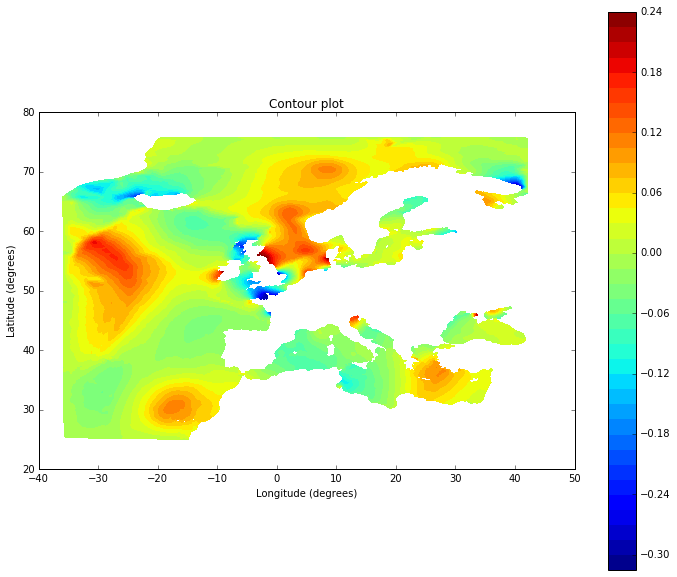

In [100]:
plt.figure(figsize=(12,10))
plt.gca().set_aspect('equal')
plt.tricontourf(x, y, tri3, h[10,:], 50, )
plt.colorbar()
plt.title('Contour plot')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.show()

## grid plot

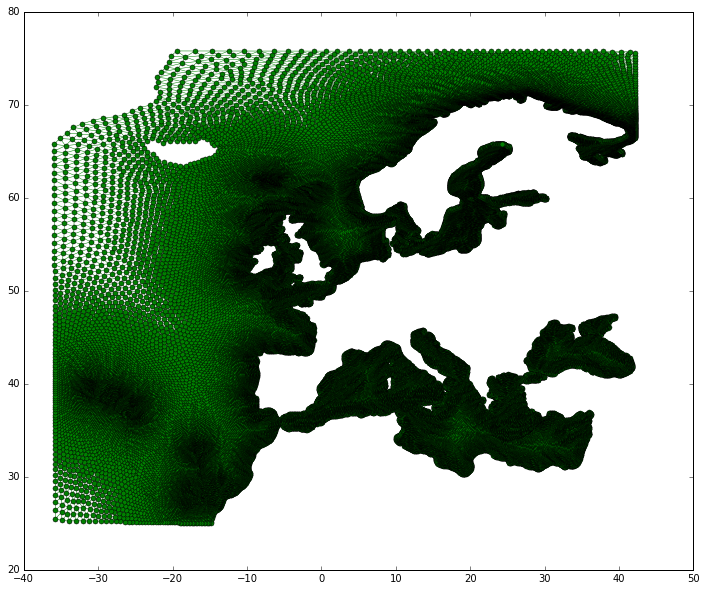

In [101]:
plt.figure(figsize=(12,10))
plt.triplot(x,y,tri3,'go-', lw=.5, markersize=5)
plt.show()

## vector plot

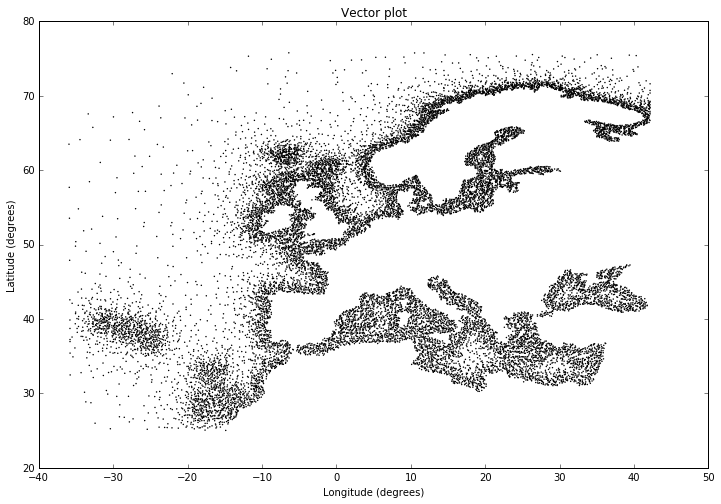

In [102]:
plt.figure(figsize=(12,10))
plt.gca().set_aspect('equal')
plt.quiver(x[::10], y[::10], U[0,::10], V[0,::10], angles='xy', scale_units='xy', scale=5)
plt.title('Vector plot')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.show()

## anim

In [38]:
def anim(z,t,title=None):
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca()
    ax.set_aspect('equal')
    v=np.linspace(z.min(),z.max(),10,endpoint=True)
    ims = []
    for i in tqdm(range(len(t))):
        im = ax.tricontourf(x, y, tri3, z[i,:], v, vmin=z.min(), vmax=z.max())
#        im = ax.contourf(x,y,z[i,:,:],v,vmin=v1,vmax=v2,latlon=True)
        add_arts = im.collections
        text = 'time={}'.format(t[i])
        #te = ax.text(90, 90, text)
        an = ax.annotate(text, xy=(0.05, 0.95), xycoords='axes fraction')
        ims.append(add_arts + [an])
    ax.set_title(title)    
#cbar_ax = fig.add_axes([0.05, 0.05, 0.85, 0.05])    
    cbar = fig.colorbar(im,ticks=v,orientation='vertical', extend='both')#,fraction=0.046, pad=0.04)
#plt.colorbar()
    return animation.ArtistAnimation(fig, ims, interval=200, blit=False,repeat=False)

In [39]:
anim(h,t,title='Storm Surge')

In [ ]:
#anim(U,t,title='U - velocity')